→ BINARY


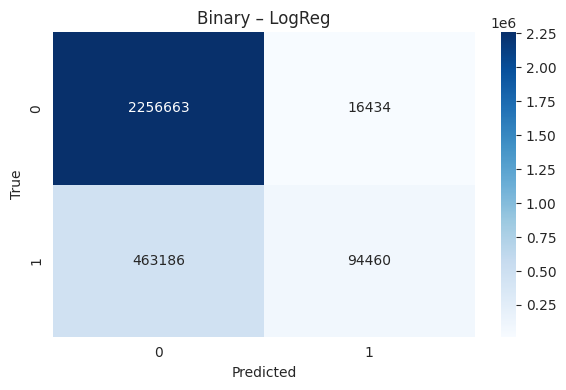

,Accuracy,Precision,Recall,F1-score
0,0.831,0.834,0.831,0.782


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:41:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1742531989799/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:41:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1742531989799/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


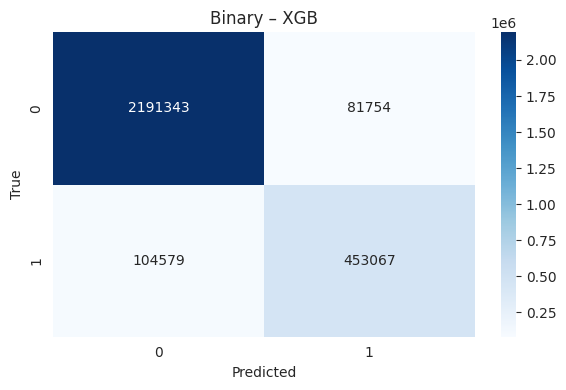

,Accuracy,Precision,Recall,F1-score
0,0.934,0.933,0.934,0.934


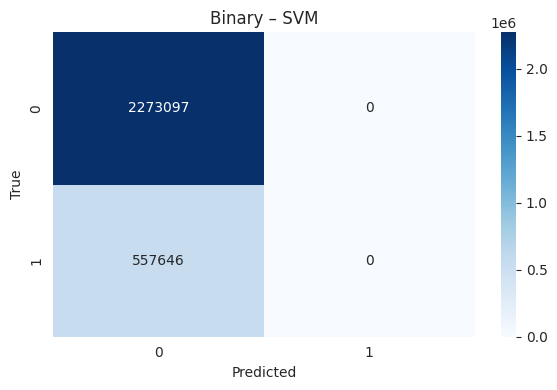

,Accuracy,Precision,Recall,F1-score
0,0.803,0.645,0.803,0.715


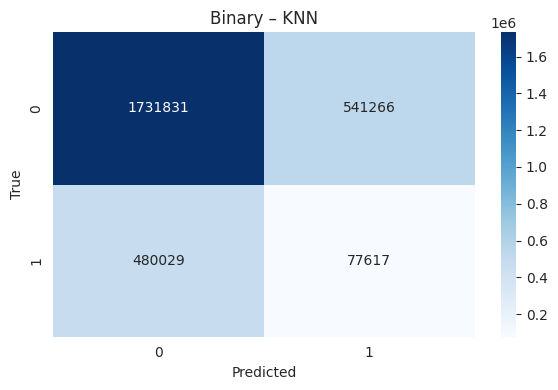

,Accuracy,Precision,Recall,F1-score
0,0.639,0.653,0.639,0.646


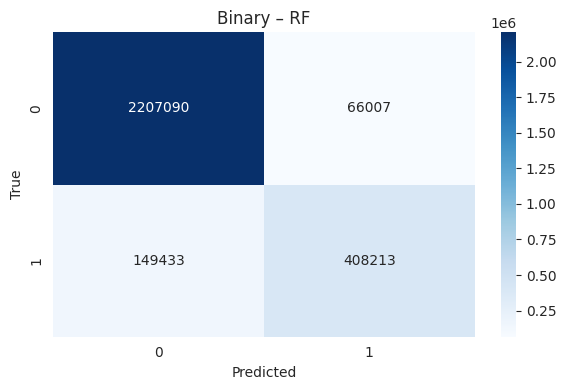

,Accuracy,Precision,Recall,F1-score
0,0.924,0.922,0.924,0.922


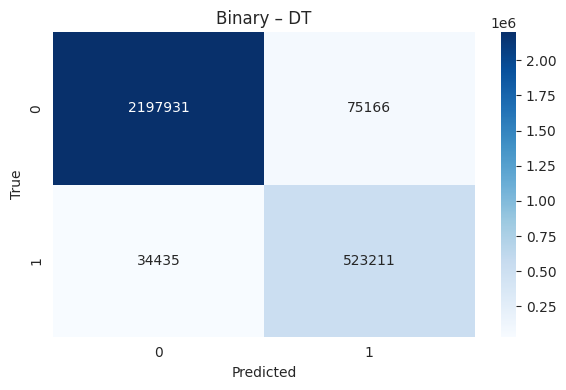

,Accuracy,Precision,Recall,F1-score
0,0.961,0.963,0.961,0.962


,Acc,Prec,Rec,F1
Model,,,,
LogReg,0.830567,0.834056,0.830567,0.781536
XGB,0.934175,0.933310,0.934175,0.933652
SVM,0.803004,0.644815,0.803004,0.715267
KNN,0.639213,0.653438,0.639213,0.646139
RF,0.923893,0.921659,0.923893,0.921502
DT,0.961282,0.962867,0.961282,0.961789


In [2]:
import glob, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC
from cuml.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

import cudf, cupy

sns.set_style("darkgrid")

# 1️⃣ Wczytanie CSV-ów
paths = glob.glob("../work/*.pcap_ISCX.csv")
df_raw = pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)
df_raw.columns = df_raw.columns.str.strip()

# 2️⃣ Poprawa etykiety binarnej
df_raw["Label"] = df_raw["Label"].astype(str).str.strip()
df_raw["BinaryLabel"] = (df_raw["Label"].str.upper() != "BENIGN").astype("int32")

# 3️⃣ Usunięcie kolumn zbędnych lub problematycznych
df = df_raw.copy()
df = df.loc[:, ~df.columns.duplicated()]
df = df[[c for c in df.columns if not c.endswith(".1")]]
df = df.drop(columns=["Label", "BinaryLabel"], errors="ignore")

# 4️⃣ Podział na cechy numeryczne i kategoryczne
num_cols = df.select_dtypes(include=["float", "int"]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]


# 5️⃣ Czyszczenie danych
for c in num_cols:
    df[c].replace([np.inf, -np.inf], np.nan, inplace=True)
    df[c].fillna(df[c].median(), inplace=True)

for c in cat_cols:
    df[c] = df[c].astype(str)
    df[c].fillna(df[c].mode().iloc[0], inplace=True)

# 6️⃣ Przygotowanie cech
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols])

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = ohe.fit_transform(df[cat_cols])
pre_ohe_input_cols = cat_cols.copy()

X_np = np.hstack([X_num, X_cat])
pre = X_np.copy()  # ← zapamiętany zestaw do ewaluacji
pre_scaler = scaler
pre_ohe = ohe

# 7️⃣ PCA
pca = PCA(n_components=30, random_state=42)
X_pca_np = pca.fit_transform(X_np)

# 8️⃣ Dane GPU + etykiety
X_pca = cudf.DataFrame(X_pca_np.astype("float32"))
y_bin = cudf.Series(df_raw["BinaryLabel"].values.astype("int32"))
y_multi = cudf.Series(pd.Categorical(df_raw["Label"]).codes.astype("int32"))

# 9️⃣ Oversampling
def balance_gpu(X, y, ratio=0.5, seed=42):
    classes, counts = cupy.unique(y, return_counts=True)
    maj, frames = int(cupy.max(counts)), []
    trg = int(ratio * maj)
    for c, n in zip(classes.tolist(), counts.tolist()):
        frag = X[y == c]
        if n < trg:
            idx = cupy.random.RandomState(seed).choice(n, trg - n)
            frag = cudf.concat([frag, frag.iloc[idx]], ignore_index=True)
            y = cupy.concatenate([y, cupy.full(trg - n, c, dtype="int32")])
        frames.append(frag)
    return cudf.concat(frames, ignore_index=True), y

def train_gpu(X, y, title, return_models=False):
    from sklearn.preprocessing import label_binarize

    X_bal, y_bal = balance_gpu(X, y)

    models = {
        "LogReg": LogisticRegression(max_iter=500),
        "XGB": XGBClassifier(
            tree_method="hist",
            device="cuda",
            use_label_encoder=False,
            eval_metric="mlogloss",
            n_estimators=50,
            max_depth=6,
            random_state=42
        ),
        "SVM": SVC(kernel="rbf", gamma="scale", max_iter=500, probability=True),
        "KNN": KNeighborsClassifier(),
        "RF": RandomForestClassifier(
            n_estimators=50,
            max_depth=10,
            n_jobs=-1,
            max_features="sqrt"),
        "DT": DecisionTreeClassifier(max_depth=10),
    }

    results = []
    models_fitted = {}
    roc_data = []

    for name, clf in models.items():
        is_cpu = "sklearn" in str(type(clf)) or "xgboost" in str(type(clf))

        # 🔁 Przygotowanie danych
        X_train = X_bal.to_numpy() if is_cpu else X_bal
        y_train = y_bal.get() if hasattr(y_bal, "get") else y_bal
        y_train = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train

        X_test = X.to_numpy() if is_cpu else X
        y_true = y.get() if hasattr(y, "get") else y
        y_true = y_true.to_numpy() if hasattr(y_true, "to_numpy") else y_true

        # 🔁 Trening
        clf.fit(X_train, y_train)
        models_fitted[name] = clf

        y_pred = clf.predict(X_test)
        y_pred = y_pred.to_array() if hasattr(y_pred, "to_array") else y_pred
        y_pred = y_pred.get() if hasattr(y_pred, "get") else y_pred
        y_pred = y_pred.to_numpy() if hasattr(y_pred, "to_numpy") else y_pred

        acc = accuracy_score(y_true, y_pred)
        pr, re, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
        results.append((name, acc, pr, re, f1))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, fmt="d", annot=True, cmap="Blues")
        plt.title(f"{title} – {name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

        metrics_df = pd.DataFrame([{
            "Accuracy": acc,
            "Precision": pr,
            "Recall": re,
            "F1-score": f1
        }])
        display(metrics_df.round(3))


    if return_models:
        return results, models_fitted
    return results

# ⏯️ Uruchomienie
print("→ BINARY")
rows_bin, models_bin = train_gpu(X_pca, y_bin, "Binary", return_models=True)

# 📊 Wyniki
bin_df = pd.DataFrame(rows_bin, columns=["Model", "Acc", "Prec", "Rec", "F1"]).set_index("Model")
display(bin_df)


In [ ]:
# Testowanie modelów wytrenownanych na danycb z CICIDS2017 na danych z ataków zebranych prze Honeypot.

[]


,Label,Count
0,Benign (0),98332
1,Attack (1),47258


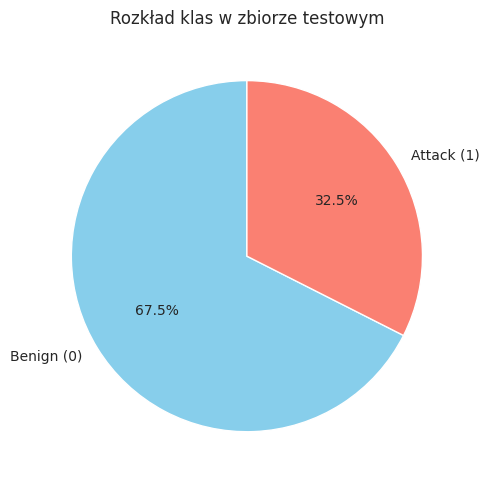

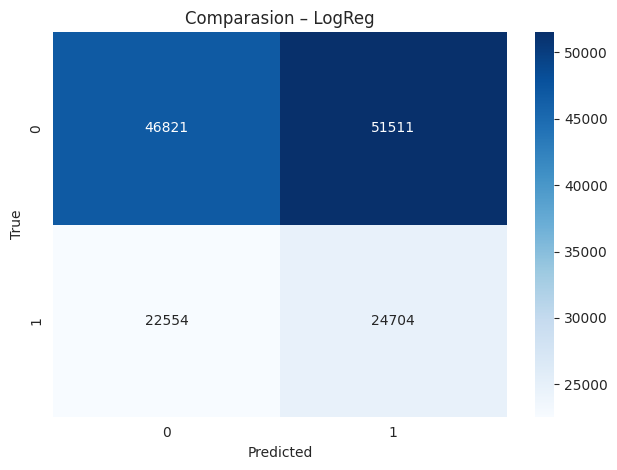

LogReg — Acc: 0.491  Prec: 0.324  Rec: 0.523  F1: 0.400


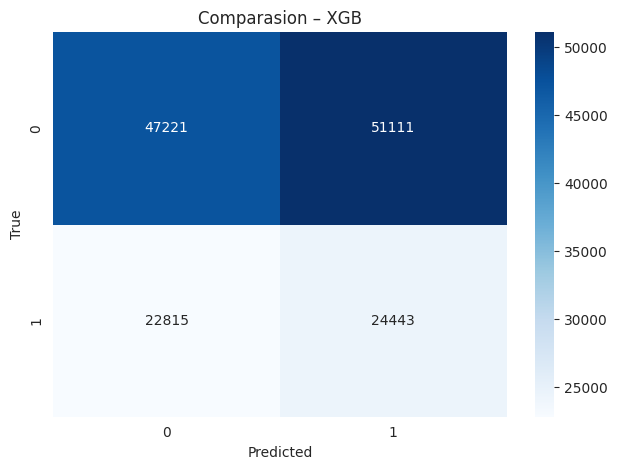

XGB — Acc: 0.492  Prec: 0.324  Rec: 0.517  F1: 0.398


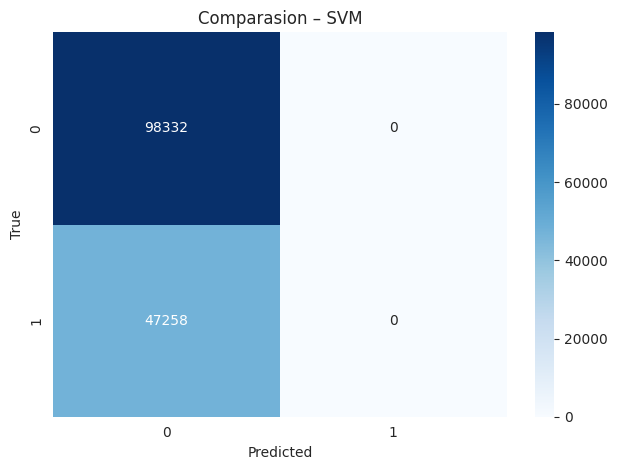

SVM — Acc: 0.675  Prec: 0.000  Rec: 0.000  F1: 0.000


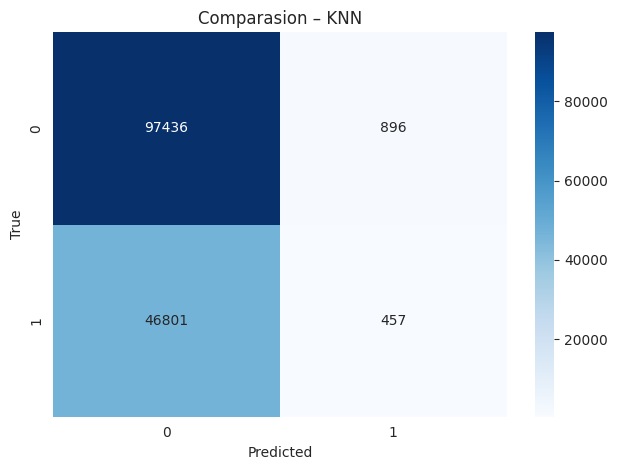

KNN — Acc: 0.672  Prec: 0.338  Rec: 0.010  F1: 0.019


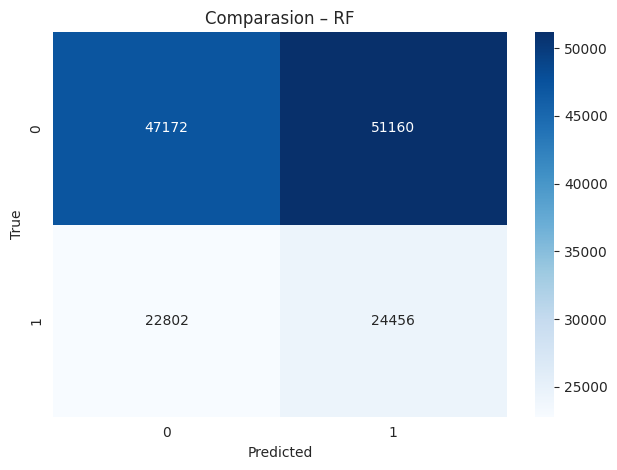

RF — Acc: 0.492  Prec: 0.323  Rec: 0.517  F1: 0.398


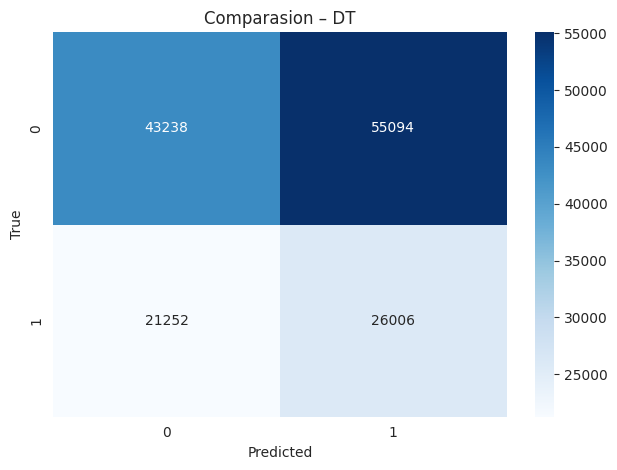

DT — Acc: 0.476  Prec: 0.321  Rec: 0.550  F1: 0.405


In [ ]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

df_new = pd.read_csv("../work/test_data.csv")
df_new.columns = df_new.columns.str.strip()
df_new = df_new.loc[:, ~df_new.columns.duplicated()]

column_rename_map = {
    "Dst Port": "Destination Port",
    "Tot Fwd Pkts": "Total Fwd Packets",
    "Tot Bwd Pkts": "Total Backward Packets",
    "TotLen Fwd Pkts": "Total Length of Fwd Packets",
    "TotLen Bwd Pkts": "Total Length of Bwd Packets",
    "Fwd Pkt Len Max": "Fwd Packet Length Max",
    "Fwd Pkt Len Min": "Fwd Packet Length Min",
    "Fwd Pkt Len Mean": "Fwd Packet Length Mean",
    "Fwd Pkt Len Std": "Fwd Packet Length Std",
    "Bwd Pkt Len Max": "Bwd Packet Length Max",
    "Bwd Pkt Len Min": "Bwd Packet Length Min",
    "Bwd Pkt Len Mean": "Bwd Packet Length Mean",
    "Bwd Pkt Len Std": "Bwd Packet Length Std",
    "Flow Byts/s": "Flow Bytes/s",
    "Flow Pkts/s": "Flow Packets/s",
    "Fwd IAT Tot": "Fwd IAT Total",
    "Bwd IAT Tot": "Bwd IAT Total",
    "Fwd Header Len": "Fwd Header Length",
    "Bwd Header Len": "Bwd Header Length",
    "Fwd Pkts/s": "Fwd Packets/s",
    "Bwd Pkts/s": "Bwd Packets/s",
    "Pkt Len Min": "Min Packet Length",
    "Pkt Len Max": "Max Packet Length",
    "Pkt Len Mean": "Packet Length Mean",
    "Pkt Len Std": "Packet Length Std",
    "Pkt Len Var": "Packet Length Variance",
    "FIN Flag Cnt": "FIN Flag Count",
    "SYN Flag Cnt": "SYN Flag Count",
    "RST Flag Cnt": "RST Flag Count",
    "PSH Flag Cnt": "PSH Flag Count",
    "ACK Flag Cnt": "ACK Flag Count",
    "URG Flag Cnt": "URG Flag Count",
    "CWE Flag Count": "CWE Flag Count",
    "ECE Flag Cnt": "ECE Flag Count",
    "Pkt Size Avg": "Average Packet Size",
    "Fwd Seg Size Avg": "Avg Fwd Segment Size",
    "Bwd Seg Size Avg": "Avg Bwd Segment Size",
    "Fwd Byts/b Avg": "Fwd Avg Bytes/Bulk",
    "Fwd Pkts/b Avg": "Fwd Avg Packets/Bulk",
    "Fwd Blk Rate Avg": "Fwd Avg Bulk Rate",
    "Bwd Byts/b Avg": "Bwd Avg Bytes/Bulk",
    "Bwd Pkts/b Avg": "Bwd Avg Packets/Bulk",
    "Bwd Blk Rate Avg": "Bwd Avg Bulk Rate",
    "Init Fwd Win Byts": "Init_Win_bytes_forward",
    "Init Bwd Win Byts": "Init_Win_bytes_backward",
    "Fwd Act Data Pkts": "act_data_pkt_fwd",
    "Fwd Seg Size Min": "min_seg_size_forward"
}
df_new.rename(columns=column_rename_map, inplace=True)
df_new.columns = df_new.columns.str.strip()

for col in pre_scaler.feature_names_in_:
    if col not in df_new.columns:
        df_new[col] = 0 

df_new["BinaryLabel"] = (df_new["Label"].str.upper() != "BENIGN").astype(int)

label_counts = df_new["BinaryLabel"].value_counts().sort_index()
label_summary = pd.DataFrame({
    "Label": ["Benign (0)", "Attack (1)"],
    "Count": [label_counts.get(0, 0), label_counts.get(1, 0)]
})
display(label_summary)

plt.figure(figsize=(5, 5))
plt.pie(label_summary["Count"], labels=label_summary["Label"], autopct="%1.1f%%", startangle=90, colors=["skyblue", "salmon"])
plt.title("Rozkład klas w zbiorze testowym")
plt.axis("equal")
plt.tight_layout()
plt.show()


y_new = df_new["BinaryLabel"].to_numpy()

for c in pre_scaler.feature_names_in_:
    df_new[c].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_new[c].fillna(df_new[c].median(), inplace=True)

X_num_new = pre_scaler.transform(df_new[pre_scaler.feature_names_in_])
X_cat_new = pre_ohe.transform(df_new[pre_ohe_input_cols])
X_new_pre = np.hstack([X_num_new, X_cat_new])
X_new_pca = pca.transform(X_new_pre)

rows = []
for name, mdl in models_bin.items():
    y_pred = mdl.predict(X_new_pca)
    if hasattr(y_pred, "to_array"): y_pred = y_pred.to_array()
    if hasattr(y_pred, "get"):      y_pred = y_pred.get()
    if hasattr(y_pred, "to_numpy"): y_pred = y_pred.to_numpy()

    acc = accuracy_score(y_new, y_pred)
    pr  = precision_score(y_new, y_pred, zero_division=0)
    re  = recall_score(y_new, y_pred, zero_division=0)
    f1  = f1_score(y_new, y_pred, zero_division=0)
    rows.append((name, acc, pr, re, f1))

    cm = confusion_matrix(y_new, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Comparasion – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    print(f"{name} — Acc: {acc:.3f}  Prec: {pr:.3f}  Rec: {re:.3f}  F1: {f1:.3f}")

results_new = pd.DataFrame(rows, columns=["Model", "Accuracy", "Precision", "Recall", "F1"]).set_index("Model")



In [9]:
print('Ewidentnie wytrenowane modele na danych z datasetu CICIDS2017, nie wykrywa rzeczywistych ataków - osiągni na poziomie ~50% to nie jest odpowiedni wynik') 

Ewidentnie wytrenowane modele na danych z datasetu CICIDS2017, nie wykrywa rzeczywistych ataków - osiągni na poziomie ~50% to nie jest odpowiedni wynik
